In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
global_path = '/Users/sujie/Desktop/pythonKaggle'

/Users/sujie/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#read the csv file
df_train = pd.read_csv(global_path+'/data/train_users_2.csv')
df_test = pd.read_csv(global_path+'/data/test_users.csv')
df_sessions = pd.read_csv(global_path+'/data/sessions.csv')

In [3]:
#get the target of the train user and delet the taraget from the data frame
target = df_train['country_destination']
df_train = df_train.drop(['country_destination'], axis=1)

In [4]:
#get the id of test
id_test = df_test['id']

In [5]:
#replace the user_id in session data as id
df_sessions['id'] = df_sessions['user_id']
df_sessions = df_sessions.drop(['user_id'],axis=1)

In [6]:
#########Preparing Session data########
print('Working on Session data...')
#Filling nan with specific value ('NAN')
df_sessions.action = df_sessions.action.fillna('NAN')
df_sessions.action_type = df_sessions.action_type.fillna('NAN')
df_sessions.action_detail = df_sessions.action_detail.fillna('NAN')
df_sessions.device_type = df_sessions.device_type.fillna('NAN')

#Action values with low frequency are changed to 'OTHER'
act_freq = 100  #Threshold for frequency
act = dict(zip(*np.unique(df_sessions.action, return_counts=True)))
df_sessions.action = df_sessions.action.apply(lambda x: 'OTHER' if act[x] < act_freq else x)

#Computing value_counts. These are going to be used in the one-hot encoding
#based feature generation (following loop).
f_act = df_sessions.action.value_counts().argsort()
f_act_detail = df_sessions.action_detail.value_counts().argsort()
f_act_type = df_sessions.action_type.value_counts().argsort()
f_dev_type = df_sessions.device_type.value_counts().argsort()

#grouping session by id. We will compute features from all rows with the same id.
dgr_sess = df_sessions.groupby(['id'])

#Loop on dgr_sess to create all the features.
samples = []
cont = 0
ln = len(dgr_sess)
for g in dgr_sess:
    if cont%10000 == 0:
        print("%s from %s" %(cont, ln))
    gr = g[1]
    l = []
    
    #the id
    l.append(g[0])
    
    #The actual first feature is the number of values.
    l.append(len(gr))
    
    sev = gr.secs_elapsed.fillna(0).values   #These values are used later.
    
    #action features
    #(how many times each value occurs, numb of unique values, mean and std)
    c_act = [0] * len(f_act)
    for i,v in enumerate(gr.action.values):
        c_act[f_act[v]] += 1
    _, c_act_uqc = np.unique(gr.action.values, return_counts=True)
    c_act += [len(c_act_uqc), np.mean(c_act_uqc), np.std(c_act_uqc)]
    l = l + c_act
    
    #action_detail features
    #(how many times each value occurs, numb of unique values, mean and std)
    c_act_detail = [0] * len(f_act_detail)
    for i,v in enumerate(gr.action_detail.values):
        c_act_detail[f_act_detail[v]] += 1 
    _, c_act_det_uqc = np.unique(gr.action_detail.values, return_counts=True)
    c_act_detail += [len(c_act_det_uqc), np.mean(c_act_det_uqc), np.std(c_act_det_uqc)]
    l = l + c_act_detail
    
    #action_type features
    #(how many times each value occurs, numb of unique values, mean and std
    #+ log of the sum of secs_elapsed for each value)
    l_act_type = [0] * len(f_act_type)
    c_act_type = [0] * len(f_act_type)
    for i,v in enumerate(gr.action_type.values):
        l_act_type[f_act_type[v]] += sev[i]   
        c_act_type[f_act_type[v]] += 1  
    l_act_type = np.log(1 + np.array(l_act_type)).tolist()
    _, c_act_type_uqc = np.unique(gr.action_type.values, return_counts=True)
    c_act_type += [len(c_act_type_uqc), np.mean(c_act_type_uqc), np.std(c_act_type_uqc)]
    l = l + c_act_type + l_act_type    
    
    #device_type features
    #(how many times each value occurs, numb of unique values, mean and std)
    c_dev_type  = [0] * len(f_dev_type)
    for i,v in enumerate(gr.device_type .values):
        c_dev_type[f_dev_type[v]] += 1 
    c_dev_type.append(len(np.unique(gr.device_type.values)))
    _, c_dev_type_uqc = np.unique(gr.device_type.values, return_counts=True)
    c_dev_type += [len(c_dev_type_uqc), np.mean(c_dev_type_uqc), np.std(c_dev_type_uqc)]        
    l = l + c_dev_type    
    
    #secs_elapsed features        
    l_secs = [0] * 5 
    l_log = [0] * 15
    if len(sev) > 0:
        #Simple statistics about the secs_elapsed values.
        l_secs[0] = np.log(1 + np.sum(sev))
        l_secs[1] = np.log(1 + np.mean(sev)) 
        l_secs[2] = np.log(1 + np.std(sev))
        l_secs[3] = np.log(1 + np.median(sev))
        l_secs[4] = l_secs[0] / float(l[1])
        
        #Values are grouped in 15 intervals. Compute the number of values
        #in each interval.
        log_sev = np.log(1 + sev).astype(int)
        l_log = np.bincount(log_sev, minlength=15).tolist()                      
    l = l + l_secs + l_log
    
    #The list l has the feature values of one sample.
    samples.append(l)
    cont += 1

#Creating a dataframe with the computed features    
col_names = []    #name of the columns
for i in range(len(samples[0])-1):
    col_names.append('c_' + str(i)) 
#preparing objects    
samples = np.array(samples)
samp_ar = samples[:, 1:].astype(np.float16)
samp_id = samples[:, 0]   #The first element in obs is the id of the sample.

#creating the dataframe        
df_agg_sess = pd.DataFrame(samp_ar, columns=col_names)
df_agg_sess['id'] = samp_id
df_agg_sess.index = df_agg_sess.id

Working on Session data...
0 from 135483
10000 from 135483
20000 from 135483
30000 from 135483
40000 from 135483
50000 from 135483
60000 from 135483
70000 from 135483
80000 from 135483
90000 from 135483
100000 from 135483
110000 from 135483
120000 from 135483
130000 from 135483


In [7]:
#conbine the train data and testing data
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df_all.index = df_all.id
#Inputing this kind of missing value with -1 (missing values in train and test)
df_all = df_all.fillna(-1)
#-unknown is another way of missing value, then = -1.
df_all = df_all.replace('-unknown-', -1)

In [8]:
df_all = df_all.drop(['date_first_booking'], axis=1)
df_all['n_null'] = np.array([sum(r == -1) for r in df_all.values])

In [9]:
dac = np.vstack(df_all.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('/')))).values)
df_all['dac_year'] = dac[:,0]
df_all['dac_month'] = dac[:,1]
df_all['dac_day'] = dac[:,2]
dac_dates = [datetime(x[0],x[1],x[2]) for x in dac]
df_all['dac_week'] = np.array([d.isocalendar()[1] for d in dac_dates])
df_all = df_all.drop(['date_account_created'], axis=1)
df_all

,id,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,n_null,dac_year,dac_month,dac_day,dac_week
id,,,,,,,,,,,,,,,,,,
gxn3p5htnn,gxn3p5htnn,20090300000000,-1,-1.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2,2010,6,28,26
820tgsjxq7,820tgsjxq7,20090500000000,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,0,2011,5,25,21
4ft3gnwmtx,4ft3gnwmtx,20090600000000,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,0,2010,9,28,39
bjjt8pjhuk,bjjt8pjhuk,20091000000000,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,0,2011,12,5,49
87mebub9p4,87mebub9p4,20091200000000,-1,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,1,2010,9,14,37
osr2jwljor,osr2jwljor,20100100000000,-1,-1.0,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,2,2010,1,1,53
lsw9q7uk0j,lsw9q7uk0j,20100100000000,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,0,2010,1,2,53
0d01nltbrs,0d01nltbrs,20100100000000,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,0,2010,1,3,53
a1vcnhxeij,a1vcnhxeij,20100100000000,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,0,2010,1,4,1


In [10]:
tfa = np.vstack(df_all.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8]]))).values)
df_all['tfa_y'] = tfa[:,0]
df_all['tfa_m'] = tfa[:,1]
df_all['tfa_d'] = tfa[:,2]
tfa_dates = [datetime(x[0],x[1],1) for x in tfa]
df_all['tfa_week'] = np.array([d.isocalendar()[1] for d in tfa_dates])
df_all = df_all.drop(['timestamp_first_active'], axis=1)
df_all

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,first_browser,n_null,dac_year,dac_month,dac_day,dac_week,tfa_y,tfa_m,tfa_d,tfa_week
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,gxn3p5htnn,-1,-1.0,facebook,0,en,direct,direct,untracked,Web,...,Chrome,2,2010,6,28,26,2009,3,0,9
820tgsjxq7,820tgsjxq7,MALE,38.0,facebook,0,en,seo,google,untracked,Web,...,Chrome,0,2011,5,25,21,2009,5,0,18
4ft3gnwmtx,4ft3gnwmtx,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,...,IE,0,2010,9,28,39,2009,6,0,23
bjjt8pjhuk,bjjt8pjhuk,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,...,Firefox,0,2011,12,5,49,2009,10,0,40
87mebub9p4,87mebub9p4,-1,41.0,basic,0,en,direct,direct,untracked,Web,...,Chrome,1,2010,9,14,37,2009,12,0,49
osr2jwljor,osr2jwljor,-1,-1.0,basic,0,en,other,other,omg,Web,...,Chrome,2,2010,1,1,53,2010,1,0,53
lsw9q7uk0j,lsw9q7uk0j,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,...,Safari,0,2010,1,2,53,2010,1,0,53
0d01nltbrs,0d01nltbrs,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,...,Safari,0,2010,1,3,53,2010,1,0,53
a1vcnhxeij,a1vcnhxeij,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,...,Safari,0,2010,1,4,1,2010,1,0,53


In [11]:
df_all['dac_tfa_secs'] = np.array([np.log(1+abs((dac_dates[i]-tfa_dates[i]).total_seconds())) for i in range(len(dac_dates))])
df_all['sig_dac_tfa'] = np.array([np.sign((dac_dates[i]-tfa_dates[i]).total_seconds()) for i in range(len(dac_dates))])
df_all

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,dac_year,dac_month,dac_day,dac_week,tfa_y,tfa_m,tfa_d,tfa_week,dac_tfa_secs,sig_dac_tfa
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,gxn3p5htnn,-1,-1.0,facebook,0,en,direct,direct,untracked,Web,...,2010,6,28,26,2009,3,0,9,17.548828,1.0
820tgsjxq7,820tgsjxq7,MALE,38.0,facebook,0,en,seo,google,untracked,Web,...,2011,5,25,21,2009,5,0,18,17.992135,1.0
4ft3gnwmtx,4ft3gnwmtx,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,...,2010,9,28,39,2009,6,0,23,17.548828,1.0
bjjt8pjhuk,bjjt8pjhuk,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,...,2011,12,5,49,2009,10,0,40,18.045085,1.0
87mebub9p4,87mebub9p4,-1,41.0,basic,0,en,direct,direct,untracked,Web,...,2010,9,14,37,2009,12,0,49,17.026225,1.0
osr2jwljor,osr2jwljor,-1,-1.0,basic,0,en,other,other,omg,Web,...,2010,1,1,53,2010,1,0,53,0.000000,0.0
lsw9q7uk0j,lsw9q7uk0j,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,...,2010,1,2,53,2010,1,0,53,11.366755,1.0
0d01nltbrs,0d01nltbrs,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,...,2010,1,3,53,2010,1,0,53,12.059896,1.0
a1vcnhxeij,a1vcnhxeij,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,...,2010,1,4,1,2010,1,0,53,12.465359,1.0


In [12]:
#Age
#(Keeping ages in 14 < age < 99 as OK and grouping others according different kinds of mistakes)
av = df_all.age.values
av = np.where(np.logical_and(av<2000, av>1900), 2014-av, av) #This are birthdays instead of age (estimating age by doing 2014 - value)
av = np.where(np.logical_and(av<14, av>0), 4, av) #Using specific value=4 for age values below 14
av = np.where(np.logical_and(av<2016, av>2010), 9, av) #This is the current year insted of age (using specific value = 9)
av = np.where(av > 99, 110, av)  #Using specific value=110 for age values above 99
df_all['age'] = av
df_all

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,dac_year,dac_month,dac_day,dac_week,tfa_y,tfa_m,tfa_d,tfa_week,dac_tfa_secs,sig_dac_tfa
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,gxn3p5htnn,-1,-1.0,facebook,0,en,direct,direct,untracked,Web,...,2010,6,28,26,2009,3,0,9,17.548828,1.0
820tgsjxq7,820tgsjxq7,MALE,38.0,facebook,0,en,seo,google,untracked,Web,...,2011,5,25,21,2009,5,0,18,17.992135,1.0
4ft3gnwmtx,4ft3gnwmtx,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,...,2010,9,28,39,2009,6,0,23,17.548828,1.0
bjjt8pjhuk,bjjt8pjhuk,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,...,2011,12,5,49,2009,10,0,40,18.045085,1.0
87mebub9p4,87mebub9p4,-1,41.0,basic,0,en,direct,direct,untracked,Web,...,2010,9,14,37,2009,12,0,49,17.026225,1.0
osr2jwljor,osr2jwljor,-1,-1.0,basic,0,en,other,other,omg,Web,...,2010,1,1,53,2010,1,0,53,0.000000,0.0
lsw9q7uk0j,lsw9q7uk0j,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,...,2010,1,2,53,2010,1,0,53,11.366755,1.0
0d01nltbrs,0d01nltbrs,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,...,2010,1,3,53,2010,1,0,53,12.059896,1.0
a1vcnhxeij,a1vcnhxeij,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,...,2010,1,4,1,2010,1,0,53,12.465359,1.0


In [13]:
#AgeRange
#(One-hot encoding of the edge according these intervals)
interv =  [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100]
def get_interv_value(age):
    iv = 20
    for i in range(len(interv)):
        if age < interv[i]:
            iv = i 
            break
    return iv
df_all['age_interv'] = df_all.age.apply(lambda x: get_interv_value(x))
df_all_ai = pd.get_dummies(df_all.age_interv, prefix='age_interv')
df_all = df_all.drop(['age_interv'], axis=1)
df_all = pd.concat((df_all, df_all_ai), axis=1)
df_all

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,age_interv_11,age_interv_12,age_interv_13,age_interv_14,age_interv_15,age_interv_16,age_interv_17,age_interv_18,age_interv_19,age_interv_20
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,gxn3p5htnn,-1,-1.0,facebook,0,en,direct,direct,untracked,Web,...,0,0,0,0,0,0,0,0,0,0
820tgsjxq7,820tgsjxq7,MALE,38.0,facebook,0,en,seo,google,untracked,Web,...,0,0,0,0,0,0,0,0,0,0
4ft3gnwmtx,4ft3gnwmtx,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,...,0,1,0,0,0,0,0,0,0,0
bjjt8pjhuk,bjjt8pjhuk,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,...,0,0,0,0,0,0,0,0,0,0
87mebub9p4,87mebub9p4,-1,41.0,basic,0,en,direct,direct,untracked,Web,...,0,0,0,0,0,0,0,0,0,0
osr2jwljor,osr2jwljor,-1,-1.0,basic,0,en,other,other,omg,Web,...,0,0,0,0,0,0,0,0,0,0
lsw9q7uk0j,lsw9q7uk0j,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,...,0,0,0,0,0,0,0,0,0,0
0d01nltbrs,0d01nltbrs,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,...,0,0,0,0,0,0,0,0,0,0
a1vcnhxeij,a1vcnhxeij,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
df_all.in

In [14]:
#One-hot-encoding features
ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    df_all_dummy = pd.get_dummies(df_all[f], prefix=f)
    df_all = df_all.drop([f], axis=1)
    df_all = pd.concat((df_all, df_all_dummy), axis=1)   

In [89]:
list(set(df_all.age_interv_5.values))

[0, 1]

In [90]:
df_agg_sess

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_448,c_449,c_450,c_451,c_452,c_453,c_454,c_455,c_456,id
id,,,,,,,,,,,,,,,,,,,,,
00023iyk9l,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,6.0,2.0,3.0,3.0,1.0,0.0,1.0,0.0,00023iyk9l
0010k6l0om,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,12.0,2.0,8.0,4.0,3.0,0.0,0.0,0.0,0010k6l0om
001wyh0pz8,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.0,30.0,9.0,8.0,1.0,0.0,0.0,0.0,0.0,001wyh0pz8
0028jgx1x1,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,3.0,5.0,4.0,1.0,0.0,0.0,0.0,0028jgx1x1
002qnbzfs5,789.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,111.0,102.0,104.0,57.0,28.0,9.0,4.0,1.0,1.0,002qnbzfs5
0031awlkjq,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0031awlkjq
0035hobuyj,489.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,159.0,66.0,47.0,35.0,38.0,12.0,5.0,0.0,1.0,0035hobuyj
00378ocvlh,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0,8.0,10.0,12.0,5.0,3.0,0.0,2.0,0.0,00378ocvlh
00389675gq,177.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,45.0,19.0,18.0,18.0,16.0,9.0,2.0,0.0,0.0,00389675gq


In [16]:
######Merging train-test with session data#################
df_all_new = pd.merge(df_all, df_agg_sess, how='left')
df_all_new = df_all_new.drop(['id'], axis=1)
df_all_new = df_all_new.fillna(-2)  #Missing features for samples without sesssion data.
#All types of null 
df_all_new['all_null'] = np.array([sum(r<0) for r in df_all_new.values])

In [17]:
df_all_new

,age,n_null,dac_year,dac_month,dac_day,dac_week,tfa_y,tfa_m,tfa_d,tfa_week,...,c_448,c_449,c_450,c_451,c_452,c_453,c_454,c_455,c_456,all_null
0,-1.0,2,2010,6,28,26,2009,3,0,9,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,458
1,38.0,0,2011,5,25,21,2009,5,0,18,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457
2,56.0,0,2010,9,28,39,2009,6,0,23,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457
3,42.0,0,2011,12,5,49,2009,10,0,40,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457
4,41.0,1,2010,9,14,37,2009,12,0,49,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457
5,-1.0,2,2010,1,1,53,2010,1,0,53,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,458
6,46.0,0,2010,1,2,53,2010,1,0,53,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457
7,47.0,0,2010,1,3,53,2010,1,0,53,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457
8,50.0,0,2010,1,4,1,2010,1,0,53,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457
9,46.0,1,2010,1,4,1,2010,1,0,53,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457


In [18]:
######Computing X, y and X_test ################
piv_train = len(target) #Marker to split df_all into train + test
vals = df_all_new.values
le = LabelEncoder()

X = vals[:piv_train]
y = le.fit_transform(target.values)
X_test = vals[piv_train:]


In [91]:
X_test

array([[  3.50000000e+01,   0.00000000e+00,   2.01400000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -1.00000000e+00,   2.00000000e+00,   2.01400000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.00000000e+00,   2.00000000e+00,   2.01400000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       ..., 
       [ -1.00000000e+00,   2.00000000e+00,   2.01400000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.00000000e+00,   2.00000000e+00,   2.01400000e+03, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.90000000e+01,   0.00000000e+00,   2.01400000e+03, ...,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00]])

In [28]:
#Classifier
xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)                  
bst = xgb.fit(X, y)
y_pred = bst.predict_proba(X_test)  

#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

In [96]:
len(y_pred[0])

12

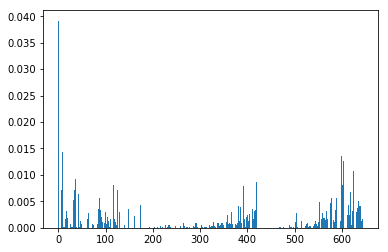

In [39]:
from matplotlib import pyplot
from xgboost import plot_importance
pyplot.bar(range(len(bst.feature_importances_)), bst.feature_importances_)
pyplot.show()
# plot_importance(bst)
# pyplot.show()

In [54]:
featureList = list(df_all_new.columns.values)
type(featureList[0])

str

In [57]:
# importance = np.zeros((644,2))
# fscore = fimp_xgb_model.booster().get_fscore()
fscore = bst.booster().get_fscore()
importanceDict = {};
i=0;
for k, v in fscore.items():
    if i<=644:
        importanceDict[featureList[i]] = v
    i=i+1;

In [59]:
import operator
sorted_importanceDict = sorted(importanceDict.items(), key=operator.itemgetter(1))

In [60]:
sorted_importanceDict

[('language_de', 1),
 ('affiliate_channel_seo', 1),
 ('affiliate_provider_facebook-open-graph', 1),
 ('first_device_type_iPad', 1),
 ('c_39', 1),
 ('c_47', 1),
 ('c_72', 1),
 ('c_86', 1),
 ('c_101', 1),
 ('c_106', 1),
 ('c_113', 1),
 ('c_116', 1),
 ('c_119', 1),
 ('c_142', 1),
 ('c_145', 1),
 ('c_166', 1),
 ('c_169', 1),
 ('c_175', 1),
 ('c_180', 1),
 ('c_186', 1),
 ('c_193', 1),
 ('c_198', 1),
 ('c_203', 1),
 ('c_207', 1),
 ('c_208', 1),
 ('c_210', 1),
 ('c_212', 1),
 ('c_218', 1),
 ('c_224', 1),
 ('c_225', 1),
 ('c_227', 1),
 ('c_229', 1),
 ('c_231', 1),
 ('c_232', 1),
 ('c_234', 1),
 ('c_235', 1),
 ('c_237', 1),
 ('c_240', 1),
 ('c_241', 1),
 ('c_242', 1),
 ('c_243', 1),
 ('c_247', 1),
 ('c_252', 1),
 ('c_253', 1),
 ('c_255', 1),
 ('c_256', 1),
 ('c_257', 1),
 ('c_258', 1),
 ('c_259', 1),
 ('signup_flow_6', 2),
 ('first_device_type_iPhone', 2),
 ('first_browser_Arora', 2),
 ('first_browser_Conkeror', 2),
 ('first_browser_Silk', 2),
 ('c_19', 2),
 ('c_25', 2),
 ('c_41', 2),
 ('c_44',

In [61]:
sub

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,IT
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,other
8,jtl0dijy2j,IT
9,jtl0dijy2j,FR


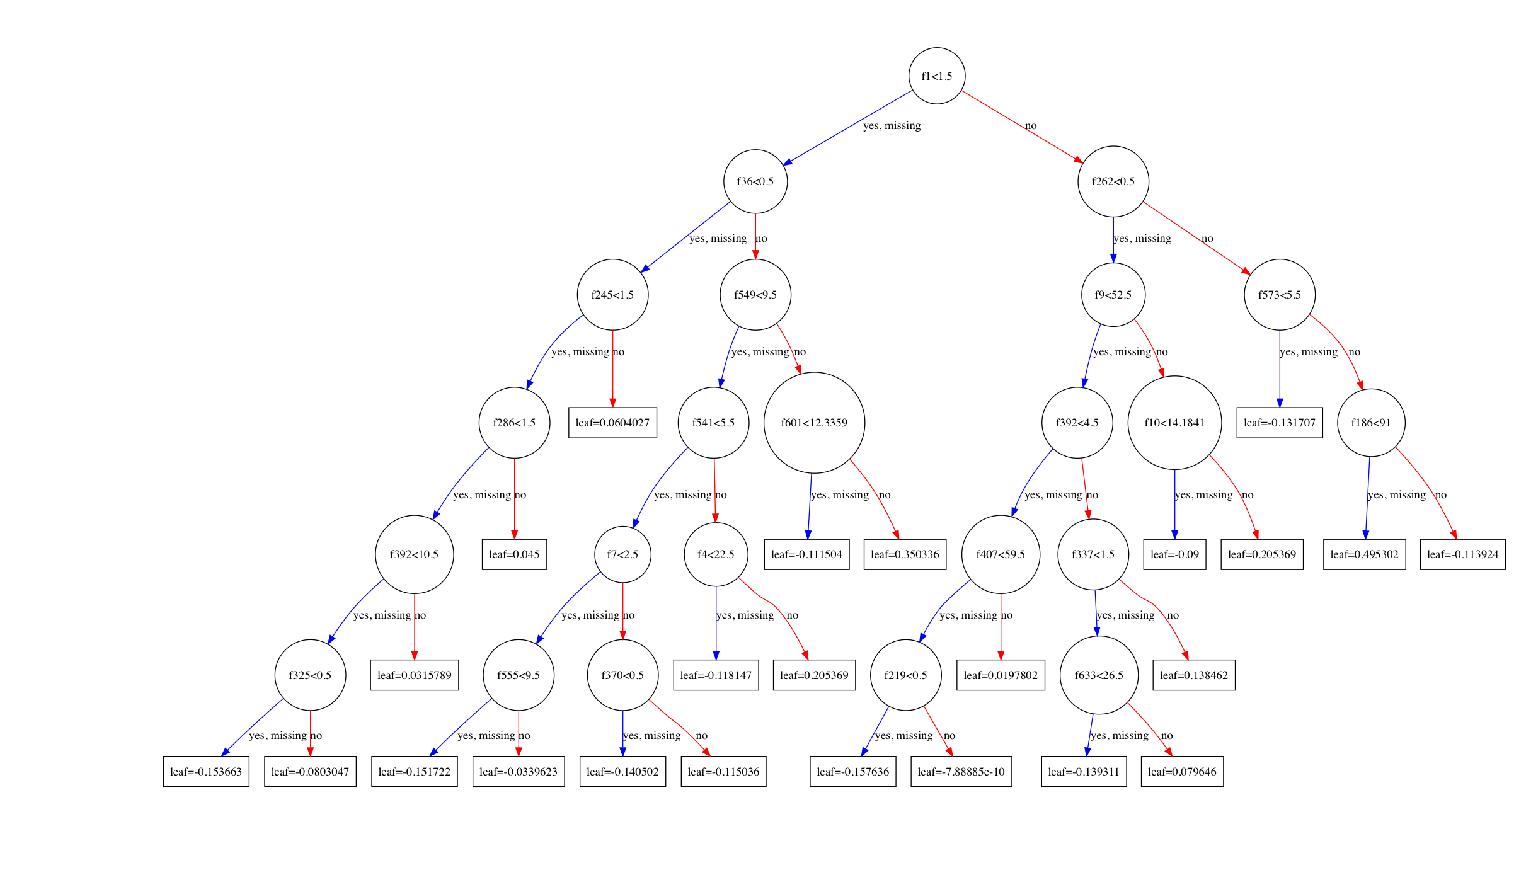

In [80]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 290
plot_tree(bst, num_trees=1)
plt.show()

In [21]:
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])

# sub.to_csv('sub.csv',index=False)

In [16]:
# #clean the age
# age = df_all['age'].tolist()
# #clean bad age data which is define in year such as 2014 or ...
# #using this data is collect in 2015 so we use 2015 as a point to calculate the age who
# #use birth year as their date. so the age_cln feature means real age
# age_cln = [2015 - x if x >= 1920 else x for x in age]
# #create a feature wihch define the childrens and people whose age is greater than 100 as -1
# #others keep real age
# age_cln2 = [-1 if x<14 or x>100 else x for x in age_cln]
# df_feature['age_cln'] = age_cln
# df_feature['age_cln2'] = age_cln2
# df_age = pd.get_dummies(df_feature.age_bucket, prefix='age_interval')
# df_feature = df_feature.drop(['age_bucket'], axis=1)
# df_feature = pd.concat((df_feature, df_age), axis=1)
# # df_age_cln = pd.DataFrame()
# # df_age_cln2 = pd.DataFrame()
# # df_age_cln = df_age_cln.assign(age_cln = age_cln)
# # df_age_cln2 = df_age_cln2.assign(age_cln2 = age_cln2)
# #add df_age_cln into df_all dataframe
# # df_all = pd.concat([df_all.reset_index(drop = True),df_age_cln],axis = 1)
# # df_all = pd.concat([df_all.reset_index(drop = True),df_age_cln2],axis = 1)

In [17]:
#cut the age feature into several parts but using min value of feature age_cln and max value of it.
#age_bucket will be a table which store the data like {age cloumn:"10" age_bucket="(4,9]"}
age_bucket = pd.cut(age,
                    [np.nanmin(age_cln),4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,89,94,99,np.nanmax(age_cln)],
                    labels = ["0-4", "5-9", "10-14", "15-19",
                              "20-24", "25-29", "30-34", "35-39",
                              "40-44", "45-49", "50-54", "55-59",
                              "60-64", "65-69", "70-74", "75-79",
                              "80-84", "85-89", "90-94", "95-99", "100+"])
df_feature['age_bucket'] = age_bucket
# df_age_bucket = pd.DataFrame()
# df_age_bucket = df_age_bucket.assign(age_bucket = age_bucket)
# df_all = pd.concat([df_all.reset_index(drop = True),df_age_bucket],axis = 1)

In [18]:
# dac = np.vstack(df_all.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('/')))).values)
# df_feature['dac_year'] = dac[:,0]
# df_feature['dac_month'] = dac[:,1]
# df_feature['dac_day'] = dac[:,2]
# dac_dates = [datetime(x[0],x[1],x[2]) for x in dac]
# df_feature['dac_week'] = np.array([d.isocalendar()[1] for d in dac_dates])
# df_feature
# dac_dates = [datetime(x[0],x[1],x[2]) for x in dac]
# np.array([d.isocalendar()[1] for d in dac_dates])
# df_all['dac_week'] = np.array([d.weekday() for d in dac_dates])
# df_all['dac']

In [19]:
# tfa = np.vstack(df_all.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8]]))).values)
# df_feature['tfa_y'] = tfa[:,0]
# df_feature['tfa_m'] = tfa[:,1]
# df_feature['tfa_d'] = tfa[:,2]
# tfa_dates = [datetime(x[0],x[1],1) for x in tfa]
# df_feature['tfa_week'] = np.array([d.isocalendar()[1] for d in tfa_dates])
# df_feature

In [20]:
# df_feature['dac_tfa_secs'] = np.array([np.log(1+abs((dac_dates[i]-tfa_dates[i]).total_seconds())) for i in range(len(dac_dates))])

In [21]:
# df_feature['sig_dac_tfa'] = np.array([np.sign((dac_dates[i]-tfa_dates[i]).total_seconds()) for i in range(len(dac_dates))])
# df_feature


In [22]:
# ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
# for f in ohe_feats:
#     df_all_dummy = pd.get_dummies(df_all[f], prefix=f)
#     df_all = df_all.drop([f], axis=1)
#     df_feature = pd.concat((df_feature, df_all_dummy), axis=1)    

In [23]:
# df_all